In [1]:
!pip3 install pyro-ppl 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 24.1 MB/s 


In [2]:
!pip install extinction

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 16.8 MB/s 


In [3]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors

import corner
import time as measure_time
import os

import pyro

import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO,Predictive
from pyro.optim import Adam

from scipy.interpolate import interp1d
import h5py
import extinction

from astropy.cosmology import FlatLambdaCDM

from spline_hsiao_fns import *

##Get constants from files

In [5]:
W0 = np.loadtxt("W0.txt")
W1 = np.loadtxt("W1.txt")
time_knots = np.loadtxt("tau_knots.txt")
wavelength_knots = np.loadtxt("l_knots.txt")
L_sigma_epsilon = np.loadtxt("L_Sigma_epsilon.txt")
M0, sigma0, rv, tauA = np.loadtxt("M0_sigma0_RV_tauA.txt")

In [6]:
g_wavelengths, _, g_norm_throughput = np.loadtxt("g_PS1.txt", skiprows = 2, unpack = True)
r_wavelengths, _, r_norm_throughput = np.loadtxt("r_PS1.txt", skiprows = 2, unpack = True)
i_wavelengths, _, i_norm_throughput = np.loadtxt("i_PS1.txt", skiprows = 2, unpack = True)
z_wavelengths, _, z_norm_throughput = np.loadtxt("z_PS1.txt", skiprows = 2, unpack = True)

Read in metadata for Foundation dataset

In [10]:
meta = pd.read_csv("meta.txt", sep='\s+', index_col = False, names = ['SNID','PEAKMJD','MWEBV','REDSHIFT_HELIO','REDSHIFT_CMB','REDSHIFT_CMB_ERR'], skiprows = 2)

In [11]:
tmax_dict = {}
mwebv_dict = {}
z_helio_dict = {}
z_cmb_dict = {}
for index, row in meta.iterrows():
  name = row['SNID']
  tmax = row['PEAKMJD']
  mwebv = row['MWEBV']
  z_helio = row['REDSHIFT_HELIO']
  z_cmb = row['REDSHIFT_CMB']
  tmax_dict[name] = tmax
  mwebv_dict[name] = mwebv
  z_helio_dict[name] = z_helio
  z_cmb_dict[name] = z_cmb

In [12]:
def get_fluxes_from_file(filename, tmax, z_helio):
  df = pd.read_csv(filename, sep=" ", header = 0, index_col = False, names = ['MJD', "FLT", 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'])
  df = df.dropna()

  # Remove time points outside of [-10., 40.]
  df['adj_time'] = (df.MJD - tmax) / (1 + z_helio)
  mask = (df['adj_time'] < 40.) & (df['adj_time'] > -10.0)
  df = df[mask]

  # Separate based on bands
  g_time = df.adj_time[df.FLT=='g'].values
  r_time = df.adj_time[df.FLT=='r'].values
  i_time = df.adj_time[df.FLT=='i'].values
  z_time = df.adj_time[df.FLT=='z'].values

  g_flux = df.FLUXCAL[df.FLT=='g'].values
  r_flux = df.FLUXCAL[df.FLT=='r'].values
  i_flux = df.FLUXCAL[df.FLT=='i'].values
  z_flux = df.FLUXCAL[df.FLT=='z'].values

  g_fluxerr = df.FLUXCALERR[df.FLT=='g'].values
  r_fluxerr = df.FLUXCALERR[df.FLT=='r'].values
  i_fluxerr = df.FLUXCALERR[df.FLT=='i'].values
  z_fluxerr = df.FLUXCALERR[df.FLT=='z'].values

  times_dict = {'g':g_time, 'r':r_time, 'i':i_time, 'z':z_time}

  observed_fluxes = [(torch.as_tensor(g_flux), torch.as_tensor(r_flux), torch.as_tensor(i_flux), torch.as_tensor(z_flux))]

  flux_errors = [(torch.as_tensor(g_fluxerr), torch.as_tensor(r_fluxerr), torch.as_tensor(i_fluxerr), torch.as_tensor(z_fluxerr))]

  return observed_fluxes, flux_errors, times_dict

In [13]:
ZPT = 27.5
M0 = -19.5
gamma = np.log(10) / 2.5

hsiao_phase, hsiao_wave, hsiao_flux = read_model_grid()

bands = ['g', 'r', 'i', 'z']
wavelengths_dict = {'g':g_wavelengths, 'r':r_wavelengths, 'i':i_wavelengths, 'z':z_wavelengths}
norm_throughput_dict = {'g':g_norm_throughput, 'r':r_norm_throughput, 'i':i_norm_throughput, 'z':z_norm_throughput}
eps_cov = torch.as_tensor(np.matmul(L_sigma_epsilon, L_sigma_epsilon.T), dtype = torch.float)

Things we can pre-calculate / helper functions
---



In [14]:
def get_lambda_int_for_band(band_wavelengths, z):
  source_wavelengths = band_wavelengths / (1 + z)
  return np.linspace(np.min(source_wavelengths), np.max(source_wavelengths), 150)

In [15]:
def calculate_band_dependent_stuff(times_dict, z_helio):
  band_Jl = {}
  band_h = {}
  band_Jt = {}
  band_xis_matrix = {}
  band_S0 = {}  

  for band in bands:
    # Calculate Jt
    times_to_interpolate = times_dict[band]
    Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))
    band_Jt[band] = Jt

    # Calculate wavelengths to interpolate
    band_wavelengths = wavelengths_dict[band]
    wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths, z = z_helio)

    # Calculate Jl (J matrix for wavelengths)
    Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))
    band_Jl[band] = Jl

    # Calculate xis matrix
    xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
    xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T
    band_xis_matrix[band] = xis_matrix

    # Interpolate throughput wavelengths
    band_norm_throughput = norm_throughput_dict[band]
    throughput_interpolator = interp1d(band_wavelengths, band_norm_throughput)
    b = throughput_interpolator([band_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z_helio)) + [band_wavelengths[-1]])

    # Calculate S0 matrix
    S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
    for i, wavelength in enumerate(wavelengths_to_interpolate):
      for j, time_point in enumerate(times_to_interpolate):
        S0[i][j] = interpolate_hsiao(time_point, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)
    band_S0[band] = S0

    # Calculate h
    xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z_helio), Av_obs, 3.1)
    dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
    h = (1 + z_helio) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)
    band_h[band] = h

  return band_Jt, band_Jl, band_xis_matrix, band_S0, band_h

## Define model

In [16]:
def model_vi_with_params(obs, z_cmb, band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors):
  # epsilon_interior = pyro.sample("eps_int", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = eps_cov))

  nu = pyro.sample("nu", dist.MultivariateNormal(torch.zeros(len(eps_cov)), covariance_matrix = torch.eye(len(eps_cov))))
  # nu = torch.zeros(54)
  epsilon_interior = torch.matmul(torch.as_tensor(L_sigma_epsilon, dtype = torch.float), nu)
  # print(epsilon_interior)

  # theta = pyro.sample("theta", dist.Uniform(low=-1.49, high=2.77))
  theta = pyro.sample("theta", dist.Normal(0., 1.0))
  # theta = torch.as_tensor(0.03430605)

  # theta = torch.as_tensor(-0.9835187)
  cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)
  # mu_s = pyro.sample("mu_s", dist.Normal(cosmo.distmod(z_helio).value, 10.)) ## fix this later
  mu_s = pyro.sample("mu_s", dist.Normal(cosmo.distmod(z_cmb).value, 10.)) ## fix this later
  # mu_s = torch.as_tensor(37.248927127193724)

  # dMs = pyro.sample("Ms", dist.Normal(torch.tensor(0.), torch.tensor(sigma0)))
  dMs = torch.tensor(0.)
  Av = pyro.sample("Av", dist.Exponential(1 / 0.252))
  # Av = torch.tensor(7.2387767)
  # Av = pyro.sample("Av", dist.Normal(0.27, 1.))

  epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
  epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)

  W = torch.as_tensor(W0) + theta*torch.as_tensor(W1) + epsilon

  generated_fluxes = []

  for band in bands:
    Jl = band_Jl[band]
    S0 = band_S0[band]
    xis_matrix = band_xis_matrix[band]
    h = band_h[band]
    Jt = band_Jt[band]

    JlWJt = torch.matmul(torch.as_tensor(Jl), torch.matmul(W, torch.as_tensor(Jt.T)))

    Stilde = torch.as_tensor(S0) * torch.exp(-gamma * (JlWJt + Av * torch.as_tensor(xis_matrix)))

    f = 10**(0.4 * (torch.as_tensor(ZPT) - mu_s - torch.as_tensor(M0) - dMs)) * torch.matmul(torch.as_tensor(h), torch.as_tensor(Stilde))
    generated_fluxes.append(f)

  # generated_fluxes = torch.stack(generated_fluxes)
  # print(generated_fluxes)
  
  if obs is not None:
    # for i in range(len(bands)):
    for i in pyro.plate("bands", len(bands)):
      # print(i)
      with pyro.plate("observations" + str(bands[i])):
        # print(len(generated_fluxes[i]))
        # for j in range(len(generated_fluxes[i])):
          pyro.sample("flux" + str(bands[i]), dist.Normal(generated_fluxes[i], flux_errors[0][i]), obs = obs[0][i])
          # print(obs[0][i][j])
        # print(generated_fluxes[i])

In [17]:
def train_with_params(model, guide, obs, z_cmb, band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, lr=0.01, n_steps=5000, verbose= False):
  pyro.get_param_store().clear()
  adam_params = {"lr": lr, "betas": (0.95, 0.999)}
  # adam = pyro.optim.Adam({"lr": 0.05}, {"clip_norm": 10.0})
  adam = pyro.optim.ClippedAdam(adam_params)
  svi = SVI(model, guide, adam, loss=Trace_ELBO())
  losses = []

  for step in range(n_steps):
      loss = svi.step(obs, z_cmb, band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors)
      losses.append(loss)
      if verbose and step % 500 == 0:
          print('[iter {}]  loss: {:.4f}'.format(step, loss))
          ## if it hasn't decreased in 3 steps, end fitting
          # if step > 2000:
          #  if losses_every_500[-1] >= losses_every_500[-2] and losses_every_500[-2] >= losses_every_500[-3]:
          #   break
  return losses

## Iterate over all supernovae

In [15]:
vi_loc = {}
vi_scale_tril = {}
laplace_vi_loc = {}
laplace_vi_scale_tril = {}

# Iterate through all supernovas in dataset
start_time = measure_time.time()

for sn in meta.SNID.values:
  print(sn)

  tmax = tmax_dict[sn]
  z_helio = z_helio_dict[sn]
  EBV_MW = mwebv_dict[sn]
  z_cmb = z_cmb_dict[sn]

  Av_obs = EBV_MW * 3.1
  observed_fluxes, flux_errors, times_dict = get_fluxes_from_file(sn + ".dat", tmax, z_helio)

  # Calculate band-dependent quantities (Jl, Jt, xis, S0, etc.)
  band_Jt, band_Jl, band_xis_matrix, band_S0, band_h = calculate_band_dependent_stuff(times_dict, z_helio)

  try:
    # autoguide_vi = pyro.infer.autoguide.AutoMultivariateNormal(model_vi_with_params, 
    #                                                           init_loc_fn = pyro.infer.autoguide.initialization.init_to_sample(), 
    #                                                           init_scale = 1.)
    
    # # Fit VI Model
    # losses = train_with_params(model_vi_with_params, autoguide_vi, observed_fluxes, z_cmb, 
    #               band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, lr=0.01, n_steps=5000)
    # vi_loc[sn] = autoguide_vi.get_posterior().loc.detach().numpy()
    # vi_scale_tril[sn] = autoguide_vi.get_posterior().scale_tril.detach().numpy()

    # np.save("vi_loc.npy", vi_loc)
    # np.save("vi_scale_tril.npy", vi_scale_tril)


    # Fit Laplace Approximation
    autoguide_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(model_vi_with_params)
    start_time = measure_time.time()
    losses = train_with_params(model_vi_with_params, autoguide_laplace, observed_fluxes, z_cmb, 
                  band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=3000)

    # Fit VI based on Laplace Approximation
    new_laplace_approx_guide = autoguide_laplace.laplace_approximation(observed_fluxes, z_cmb, 
                  band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors,)
    losses = train_with_params(model_vi_with_params, new_laplace_approx_guide, observed_fluxes, z_cmb, 
                  band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=5000)
    laplace_vi_loc[sn] = new_laplace_approx_guide.get_posterior().loc.detach().numpy()
    laplace_vi_scale_tril[sn] = new_laplace_approx_guide.get_posterior().scale_tril.detach().numpy()


    np.save("laplace_vi_loc_redo.npy", laplace_vi_loc)
    np.save("laplace_vi_scale_tril_redo.npy", laplace_vi_scale_tril)

  except:
    print("trying again for", sn)
    try:
      # Fit Laplace Approximation
      autoguide_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(model_vi_with_params)
      start_time = measure_time.time()
      losses = train_with_params(model_vi_with_params, autoguide_laplace, observed_fluxes, z_cmb, 
                    band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=3000)

      # Fit VI based on Laplace Approximation
      new_laplace_approx_guide = autoguide_laplace.laplace_approximation(observed_fluxes, z_cmb, 
                    band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors,)
      losses = train_with_params(model_vi_with_params, new_laplace_approx_guide, observed_fluxes, z_cmb, 
                    band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=5000)
      laplace_vi_loc[sn] = new_laplace_approx_guide.get_posterior().loc.detach().numpy()
      laplace_vi_scale_tril[sn] = new_laplace_approx_guide.get_posterior().scale_tril.detach().numpy()


      np.save("laplace_vi_loc_redo.npy", laplace_vi_loc)
      np.save("laplace_vi_scale_tril_redo.npy", laplace_vi_scale_tril)
    except:
      print("Fitting did not work for", sn)

end_time = measure_time.time()
print("Time:", end_time - start_time, "seconds")



2016W
2016afk
ASASSN-15bc
ASASSN-15fa
ASASSN-15fs
ASASSN-15go
ASASSN-15hg
ASASSN-15il
ASASSN-15jl
ASASSN-15jt
ASASSN-15kx
ASASSN-15la
ASASSN-15lg
ASASSN-15lu
ASASSN-15mf
ASASSN-15mg
ASASSN-15mi
ASASSN-15np
ASASSN-15nq
ASASSN-15nr
ASASSN-15od
trying again for ASASSN-15od
ASASSN-15oh
ASASSN-15pm
ASASSN-15pn
ASASSN-15pr
ASASSN-15sf
ASASSN-15ss
ASASSN-15tg
ASASSN-15ti
ASASSN-15tz
ASASSN-15uu
ASASSN-15uv
ASASSN-15uw
ASASSN-16ad
ASASSN-16aj
ASASSN-16av
ASASSN-16ay
ASASSN-16bc
ASASSN-16bq
ASASSN-16br
ASASSN-16ch
ASASSN-16cs
ASASSN-16ct
ASASSN-16db
ASASSN-16dw
ASASSN-16em
ASASSN-16fo
ASASSN-16fs
ASASSN-16hc
ASASSN-16hr
ASASSN-16hz
ASASSN-16ip
ASASSN-16lg
ASASSN-16oz
trying again for ASASSN-16oz
ASASSN-17aj
ASASSN-17at
ASASSN-17bs
ASASSN-17co
ASASSN-17eb
AT2016aj
AT2016bln
trying again for AT2016bln
Fitting did not work for AT2016bln
AT2016cor
AT2016cvv
AT2016cvw
AT2016cyt
trying again for AT2016cyt
Fitting did not work for AT2016cyt
AT2016eoa
AT2016ews
AT2016fbk
AT2016gmg
AT2016gsu
AT2016hns
A

In [34]:
laplace_loc_dict1 = np.load("laplace_vi_loc(3).npy", allow_pickle = True).item()
laplace_loc_dict2 = np.load("laplace_vi_loc.npy", allow_pickle = True).item()
laplace_loc_dict1.update(laplace_loc_dict2)
print(len(list(laplace_loc_dict1.keys())))
np.save("foundation_laplace_vi_loc.npy", laplace_loc_dict1)

146


In [35]:
laplace_scale_tril_dict1 = np.load("laplace_vi_scale_tril(4).npy", allow_pickle = True).item()
laplace_scale_tril_dict2 = np.load("laplace_vi_scale_tril.npy", allow_pickle = True).item()
laplace_scale_tril_dict1.update(laplace_scale_tril_dict2)
print(len(list(laplace_scale_tril_dict1.keys())))
np.save("foundation_laplace_vi_scale_tril.npy", laplace_scale_tril_dict1)

146


In [36]:
vi_scale_tril_dict1 = np.load("vi_scale_tril(4).npy", allow_pickle = True).item()
vi_scale_tril_dict2 = np.load("vi_scale_tril.npy", allow_pickle = True).item()
vi_scale_tril_dict1.update(vi_scale_tril_dict2)
print(len(list(vi_scale_tril_dict1.keys())))
np.save("foundation_vi_scale_tril.npy", vi_scale_tril_dict1)

150


In [37]:
vi_loc_dict1 = np.load("vi_loc(4).npy", allow_pickle = True).item()
vi_loc_dict2 = np.load("vi_loc.npy", allow_pickle = True).item()
vi_loc_dict1.update(vi_loc_dict2)
print(len(list(vi_loc_dict1.keys())))
np.save("foundation_vi_loc.npy", vi_loc_dict1)

150


In [42]:
np.load("foundation_vi_loc.npy", allow_pickle = True).item()

150

## Make Hubble Diagram

In [21]:
vi_loc_dict = np.load("foundation_vi_loc.npy", allow_pickle = True).item()
laplace_vi_loc_dict = np.load("laplace_vi_loc_redo.npy", allow_pickle = True).item()
laplace_vi_scale_tril_dict = np.load("laplace_vi_scale_tril_redo.npy", allow_pickle = True).item()
vi_scale_tril_dict = np.load("foundation_vi_scale_tril.npy", allow_pickle = True).item()

In [43]:
for sn in np.setdiff1d(meta.SNID.values, list(laplace_vi_loc_dict.keys())):
  print(sn)

  tmax = tmax_dict[sn]
  z_helio = z_helio_dict[sn]
  EBV_MW = mwebv_dict[sn]
  z_cmb = z_cmb_dict[sn]

  Av_obs = EBV_MW * 3.1
  observed_fluxes, flux_errors, times_dict = get_fluxes_from_file(sn + ".dat", tmax, z_helio)

  # Calculate band-dependent quantities (Jl, Jt, xis, S0, etc.)
  band_Jt, band_Jl, band_xis_matrix, band_S0, band_h = calculate_band_dependent_stuff(times_dict, z_helio)

  # Fit Laplace Approximation
  autoguide_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(model_vi_with_params)
  start_time = measure_time.time()
  losses = train_with_params(model_vi_with_params, autoguide_laplace, observed_fluxes, z_cmb, 
                band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=3000)

  # Fit VI based on Laplace Approximation
  new_laplace_approx_guide = autoguide_laplace.laplace_approximation(observed_fluxes, z_cmb, 
                band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors,)
  losses = train_with_params(model_vi_with_params, new_laplace_approx_guide, observed_fluxes, z_cmb, 
                band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=5000)
  loc = new_laplace_approx_guide.get_posterior().loc.detach().numpy()
  scale_tril = new_laplace_approx_guide.get_posterior().scale_tril.detach().numpy()


AT2016bln
AT2016cyt


_LinAlgError: ignored

In [23]:
vi_mus = []
vi_vars = []
laplace_vi_mus = []
laplace_vi_vars = []

vi_z_cmbs = []

laplace_vi_z_cmbs = []


for sn in list(laplace_vi_loc_dict.keys()):
  try:
    vi_mus.append(vi_loc_dict[sn][-2])
    vi_scale_tril = vi_scale_tril_dict[sn]
    # Calculate covariance matrix from scale_tril (sigma = LL^T)
    vi_vars.append(np.matmul(vi_scale_tril, vi_scale_tril.T)[-2][-2])
    vi_z_cmbs.append(z_cmb_dict[sn])
  except:
    pass

  try:
    laplace_vi_mus.append(laplace_vi_loc_dict[sn][-2])
    laplace_vi_scale_tril = laplace_vi_scale_tril_dict[sn]
    laplace_vi_vars.append(np.matmul(laplace_vi_scale_tril, laplace_vi_scale_tril.T)[-2][-2])
    laplace_vi_z_cmbs.append(z_cmb_dict[sn])
  except:
    pass

VI Hubble diagram (I think some of them needed more training)

Text(0, 0.5, 'd')

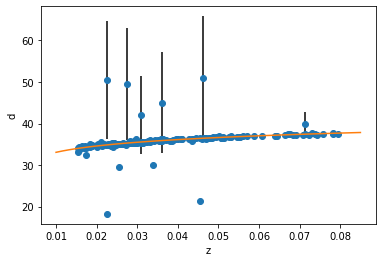

In [24]:
linspace_z = np.linspace(0.01, 0.085)

cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)
cosmo_distmod_values = np.array([cosmo.distmod(z).value for z in linspace_z])

plt.plot(vi_z_cmbs, vi_mus, 'o')
plt.plot(linspace_z, cosmo_distmod_values)
plt.errorbar(vi_z_cmbs, vi_mus, np.sqrt(vi_vars), linestyle = 'None', color = 'k')
plt.xlabel("z")
plt.ylabel("d")
# plt.ylim(32, 39)

VI from Laplace Hubble Diagram

In [29]:
predictions = laplace_vi_mus
targets = np.array([cosmo.distmod(z).value for z in laplace_vi_z_cmbs])

rmse = np.sqrt(np.mean((predictions-targets)**2))
print(rmse)

0.13016658733873537


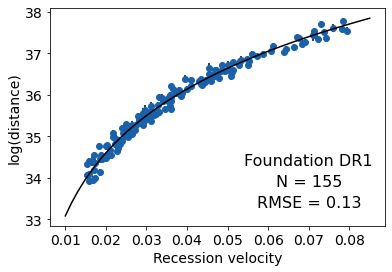

In [30]:
f = plt.figure()
plt.plot(laplace_vi_z_cmbs, laplace_vi_mus, 'o', color = (0.104,0.382,0.664))
plt.plot(linspace_z, cosmo_distmod_values, color = 'k')
plt.errorbar(laplace_vi_z_cmbs, laplace_vi_mus, np.sqrt(laplace_vi_vars), linestyle = 'None', color = 'k')
plt.xlabel("Recession velocity", fontsize =14)
plt.ylabel("log(distance)", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.text(0.07, 34.3, "Foundation DR1", fontsize = 16, horizontalalignment = 'center')
plt.text(0.07, 33.8, "N = " + str(len(laplace_vi_z_cmbs)), fontsize = 16, horizontalalignment = 'center')
plt.text(0.07, 33.3, "RMSE = " + str(round(rmse,2)), fontsize = 16, horizontalalignment = 'center')
f.savefig("HubbleDiagram.pdf", bbox_inches = 'tight')
# plt.title("Foundation dataset distances- VI initialized with Laplace", fontsize = 12)

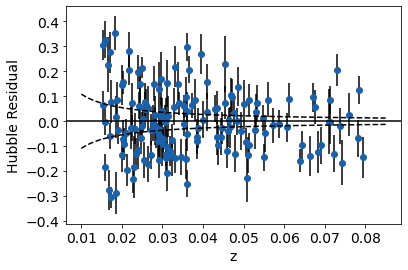

In [31]:
g = plt.figure()
plt.plot(laplace_vi_z_cmbs, laplace_vi_mus - np.array([cosmo.distmod(z).value for z in laplace_vi_z_cmbs]), 'o',color = (0.104,0.382,0.664))

plt.errorbar(laplace_vi_z_cmbs, laplace_vi_mus - np.array([cosmo.distmod(z).value for z in laplace_vi_z_cmbs]), np.sqrt(laplace_vi_vars), linestyle = 'None', color = 'k')


sigma_pec = 150
c = 300000

sigma_envelope = np.array([(5 / (z * np.log(10))) * (sigma_pec / c) for z in linspace_z])

plt.plot(linspace_z, sigma_envelope, marker = 'None', linestyle = 'dashed', color = 'k')
plt.plot(linspace_z, -sigma_envelope, marker = 'None', linestyle = 'dashed', color = 'k')

plt.axhline(0., color = 'k')

plt.xlabel("z", fontsize = 14)
plt.ylabel("Hubble Residual", fontsize = 14)
# plt.ylim(-1, 1)
# plt.title("Foundation dataset residuals- VI initialized with Laplace", fontsize = 12)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()
g.savefig("HubbleResiduals.pdf", bbox_inches = 'tight')

Calculate RMSE

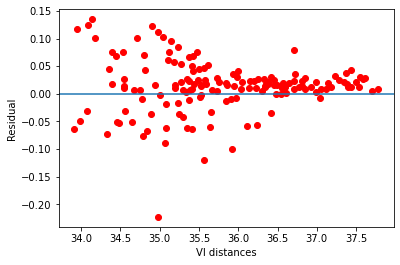

In [33]:
mu_residuals = []
av_residuals = []
theta_residuals = []

mcmc_mus = []
mcmc_av = []
mcmc_theta = []
for sn in list(laplace_vi_loc_dict.keys()):
  #   vi_mus.append(vi_loc_dict[sn][-2])
  # vi_scale_tril = vi_scale_tril_dict[sn]
  # # Calculate covariance matrix from scale_tril (sigma = LL^T)
  # vi_vars.append(np.matmul(vi_scale_tril, vi_scale_tril.T)[-2][-2])
  # vi_z_cmbs.append(z_cmb_dict[sn])

  estimated_dist = np.mean(np.load(sn + "_chains_210610_135216.npy", allow_pickle = True).item()['mu'])
  estimated_av = np.mean(np.load(sn + "_chains_210610_135216.npy", allow_pickle = True).item()['AV'])
  estimated_theta = np.mean(np.load(sn + "_chains_210610_135216.npy", allow_pickle = True).item()['theta'])

  mcmc_mus.append(estimated_dist)
  mcmc_av.append(estimated_av)
  mcmc_theta.append(estimated_theta)

  # print(estimated_dist)
  # print(vi_loc_dict[sn][-2])
  # plt.plot(laplace_vi_loc_dict[sn][-2], estimated_dist, 'bo')
  plt.plot(laplace_vi_loc_dict[sn][-2], estimated_dist - laplace_vi_loc_dict[sn][-2], 'ro')
  mu_residuals.append(estimated_dist - laplace_vi_loc_dict[sn][-2])
  av_residuals.append(estimated_av - np.exp(laplace_vi_loc_dict[sn][-1]))
  # print(laplace_vi_loc_dict[sn][-1])
  theta_residuals.append(estimated_av - laplace_vi_loc_dict[sn][-3])



# plt.plot(np.linspace(33,38), np.linspace(33, 38), color = 'tab:orange')
plt.xlabel("VI distances")
# plt.ylabel("MCMC distances")
plt.ylabel("Residual")
plt.axhline(0)

plt.show()

In [44]:
np.mean(mu_residuals) / (np.std(mu_residuals) / np.sqrt(len(mu_residuals)))

3.5257235708153103

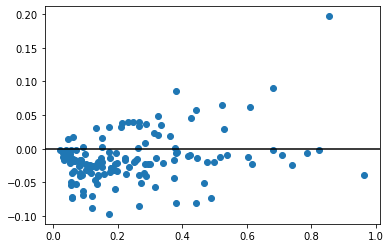

In [36]:
plt.plot(mcmc_av, av_residuals, 'o')
plt.axhline(0, color = 'k')

Text(0.5, 0.98, 'Parameter residuals for Foundation dataset')

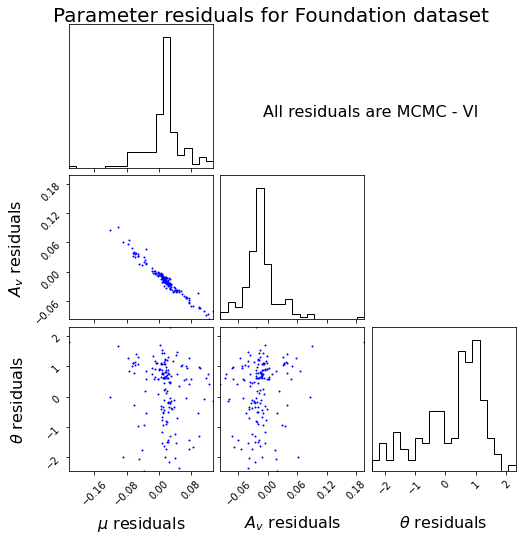

In [67]:
figure = corner.corner(np.vstack((np.array(mu_residuals), av_residuals, theta_residuals)).T, 
              plot_contours = False, plot_datapoints =  True, plot_density = False, 
              data_kwargs = {'color':'b', 'alpha':1, 'marker':'o'}, 
              labels = ['${\\mu}$ residuals', '${A_v}$ residuals', '${\\theta}$ residuals'],
              label_kwargs = {'fontsize':16})
plt.text(-6,65,"All residuals are MCMC - VI", fontsize = 16)
figure.suptitle("Parameter residuals for Foundation dataset", fontsize = 20)
